## Intro
For this part of the project I will be cleaning and performing exploritory data analysis.
The Goal is to perform regression analysis to see how time and power correlate to input voltage

Load the relevant libraries 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd

## Import the data
Let's take a look at this dataset to get a feel for it. I can see that two of our values are of type float64 and one is of type int. 

In [5]:
original_df = pd.read_csv('ex_1.csv')

In [6]:
df = original_df.copy()

In [7]:
df.head(11)

,time,input_voltage,el_power
0,810.07028,10,1228.791720
1,811.06938,10,1223.041745
2,812.06848,10,1244.960866
3,813.06758,10,1229.259058
4,814.06668,10,1248.117024
5,815.06578,10,1262.974403
6,816.06488,10,1248.077560
7,817.06398,10,1245.101476
8,818.06308,10,1275.365542
9,819.06218,10,1263.101210


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9920 entries, 0 to 9919
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   time           9920 non-null   float64
 1   input_voltage  9920 non-null   int64  
 2   el_power       9920 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 232.6 KB


In [9]:
df.describe()

,time,input_voltage,el_power
count,9920.000000,9920.000000,9920.000000
mean,5765.317878,6.822480,2162.427874
std,2861.440154,3.485288,1009.468755
min,810.070280,3.000000,932.837260
25%,3287.588505,3.000000,990.027512
50%,5765.106730,10.000000,2709.354147
75%,8243.140355,10.000000,3116.416457
max,10720.658580,10.000000,3249.891217


In [10]:
df.shape

(9920, 3)

## Cleaning The data
First I check if their's any values to drop, since their is none we then go on to checking for outliers and renaming some of the variables to make it easier to understand.I then perform a bit of exploratory data anylsis by using a scatterplot and heatmap to visualize the relationships to see how they correlate 

In [12]:
df.isnull().sum()

time             0
input_voltage    0
el_power         0
dtype: int64

<Axes: >

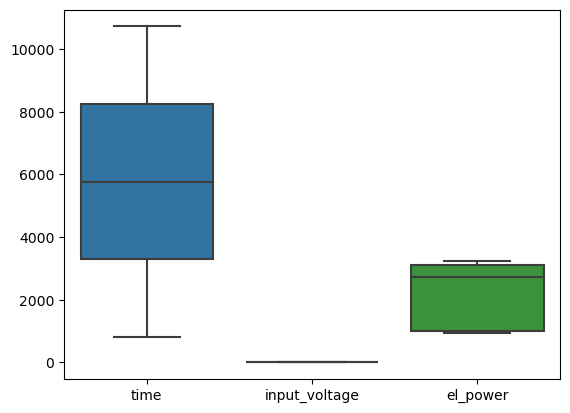

In [13]:
outlier_df = df[['time', 'input_voltage', 'el_power']]
sns.boxplot(data=outlier_df)

In [14]:
df = df.rename(columns = {'el_power': 'power'})
df.tail(11)

,time,input_voltage,power
9909,10710.66758,3,953.697653
9910,10711.66668,3,945.234157
9911,10712.66578,3,961.336850
9912,10713.66488,3,954.077284
9913,10714.66398,3,968.619166
9914,10715.66308,3,942.839023
9915,10716.66218,3,962.030262
9916,10717.66128,3,963.213626
9917,10718.66038,3,947.956869
9918,10719.65948,3,944.314505


<Axes: xlabel='time', ylabel='power'>

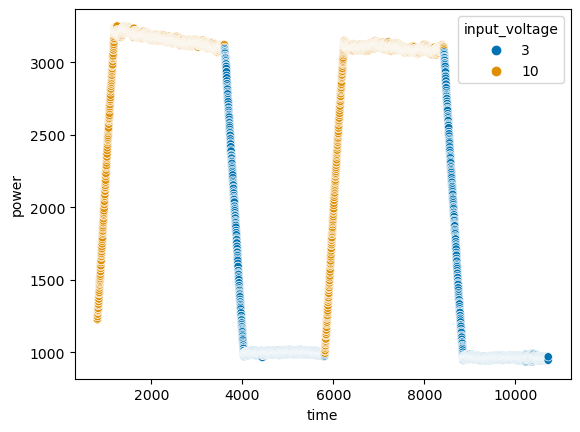

In [15]:
sns.scatterplot(data=df, x='time',y='power',hue='input_voltage',palette='colorblind')

This scatterplot shows that power exhibits a recurrent pattern over time, with no signs of a linear relationship. Voltage increases as power increases and decreases as power decreases. Additionally, power stagnates briefly before fluctuating.

<Axes: >

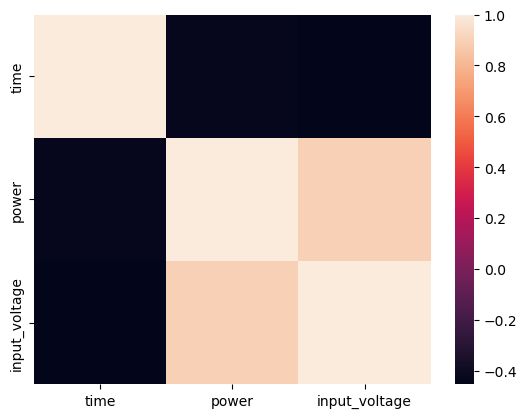

In [17]:
sns.heatmap(df[['time','power','input_voltage']].corr())

This heatmap reveals a low correlation between time and power and a stronger correlation between input_voltage and power.
Additionaly it shows a weak correlation between input_voltage and time.

In [19]:
df.to_csv('cleaned_train_dataset.csv')

Now that we have saved the dataset, let's move on to the preprocessing stage. Since there are only three variables (features), there is no need to select variables to avoid overfitting.

In [43]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [22]:
train_df = pd.read_csv('cleaned_train_dataset.csv')
test_df = pd.read_csv('cleaned_testt_data.csv')

In [23]:
X = train_df.drop(columns=['power'])
y = train_df['power']

In [47]:
X_train, X_temp,y_train, y_temp = train_test_split (X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [49]:
rf = RandomForestRegressor(random_state=42)

In [51]:
param_grid = {
    'n_estimators': [50,100,200],
    'max_depth': [None,10,20],
    'min_samples_split':[2,5,10]
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print(f'Best Parameters: {grid_search.best_params_}')

Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}


In [53]:
y_val_pred = best_rf.predict(X_val)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_val, y_val_pred)

print("Validation Set Performance:")
print(f"MAE: {val_mae:.4f}")
print(f"RMSE: {val_rmse:.4f}")
print(f"R2 Score; {val_r2:.4f}")

Validation Set Performance:
MAE: 11.0364
RMSE: 12.3713
R2 Score; 0.9998


In [55]:
y_pred = best_rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Final Test Set Performance:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

Final Test Set Performance:
MAE: 11.0743
RMSE: 12.3306
R2 Score: 0.9999


Since the validation set and test set are identical, there are no signs of overfitting. The predictions seem to be off by only 11 units (MAE) and 12 units (RMSE), with a prediction-to-variance score of 99% (R²).

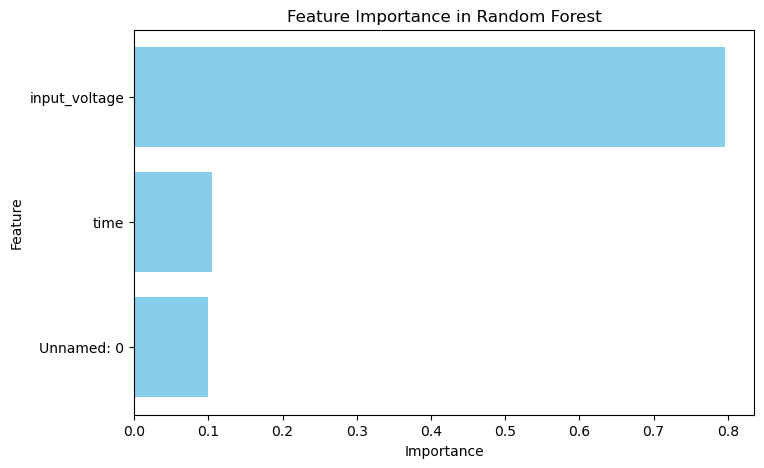

In [61]:
feature_importance = best_rf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8,5))
plt.barh(feature_names, feature_importance, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest')
plt.show()

I forgot to check the columns and rows for missing data (Unnamed: 0), but based on the feature importance, it seems that the unnamed columns belonged to the time feature. Since this feature has very low importance, the dataset is good to go.

In [65]:
import joblib

In [67]:
joblib.dump(best_rf, "random_forest_model.pkl")
print("Model saved as 'random_forest_model.pk1'")

Model saved as 'random_forest_model.pk1'
